In [1]:
#Read in standard packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import geopandas as gpd

In [2]:
#read in ML packages/modules
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [3]:
#Read in dask package and set up to allow for faster compute times. Distributes computing among all availabel preocessors
from dask import dataframe as dd
import joblib
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
cluster.scheduler, cluster.workers

C:\Users\bwils\anaconda3\envs\pumpitup\lib\site-packages\distributed\node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 58799 instead
  warnings.warn(


(<Scheduler: "tcp://127.0.0.1:58803" processes: 3 cores: 6>,
 {0: <Nanny: tcp://127.0.0.1:58825, threads: 2>,
  1: <Nanny: tcp://127.0.0.1:58828, threads: 2>,
  2: <Nanny: tcp://127.0.0.1:58822, threads: 2>})

### Read in training/testing data

In [4]:
#Read in train/test data
train_X = pd.read_pickle('Data/train_test/train_X.pkl')
test_X = pd.read_pickle('Data/train_test/test_X.pkl')
train_y = pd.read_pickle('Data/train_test/train_y.pkl')
test_y = pd.read_pickle('Data/train_test/test_y.pkl')

# Random Forest Classifier

We will start with the Random Forest Classifier which is pretty common becuase of it's predicitive power. We will run using all features first and then we can compare the different amount of features to see what performs best.

In [5]:
rf = RandomForestClassifier(verbose=True)
with joblib.parallel_backend('dask'):
    rf.fit(train_X, train_y)
rf.score(test_X, test_y)

[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   21.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.3s finished


0.8016835016835017

This performs pretty well. WWe can further tune some hyperparamters to possibly get higher accuracy. Let's start with class weights. But we need to first save the parameters and score for later review.

In [6]:
rf_deets = pd.DataFrame(rf.get_params(), index=['RF_OBO'])
rf_deets.insert(0, value=rf.score(test_X, test_y), column='Accuracy')
rf_deets

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished


,Accuracy,bootstrap,ccp_alpha,class_weight,criterion,max_depth,max_features,max_leaf_nodes,max_samples,min_impurity_decrease,min_impurity_split,min_samples_leaf,min_samples_split,min_weight_fraction_leaf,n_estimators,n_jobs,oob_score,random_state,verbose,warm_start
RF_OBO,0.801684,True,0.0,None,gini,None,auto,None,None,0.0,None,1,2,0.0,100,None,False,None,True,False


In [7]:
rf_class = RandomForestClassifier(class_weight='balanced_subsample',verbose=True)
with joblib.parallel_backend('dask'):
    rf_class.fit(train_X, train_y)
rf_class.score(test_X, test_y)

[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.2s finished


0.8043097643097643

We do see some improvement here, over a tenth of a percentage point. We will keep the class weights as we try different amounts of estimators and the two types of criterion.

In [8]:
a = rf_class.get_params()
a['Accuracy'] = rf_class.score(test_X, test_y)
rf_deets = pd.concat([rf_deets, pd.DataFrame(a, index=['RF_CLASS'])], axis=0, join='outer')
rf_deets

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.0s finished


,Accuracy,bootstrap,ccp_alpha,class_weight,criterion,max_depth,max_features,max_leaf_nodes,max_samples,min_impurity_decrease,min_impurity_split,min_samples_leaf,min_samples_split,min_weight_fraction_leaf,n_estimators,n_jobs,oob_score,random_state,verbose,warm_start
RF_OBO,0.801684,True,0.0,None,gini,None,auto,None,None,0.0,None,1,2,0.0,100,None,False,None,True,False
RF_CLASS,0.804310,True,0.0,balanced_subsample,gini,None,auto,None,None,0.0,None,1,2,0.0,100,None,False,None,True,False


In [9]:
n_estimators = [50, 100, 250, 500]
criterion = ['gini', 'entropy']
count=1
for c in criterion:
    for n in n_estimators:
        rf_est = RandomForestClassifier(n_estimators=n, criterion=c, class_weight='balanced_subsample', verbose=True)
        with joblib.parallel_backend('dask'):
            rf_est.fit(train_X, np.ravel(train_y))
        deets = rf_est.get_params()
        deets['Accuracy']=rf_est.score(test_X, test_y)
        rf_deets = pd.concat([rf_deets, pd.DataFrame(deets, index=['RF_{n}_{c}'.format(n=n, c=c)])], axis=0, join='outer')
rf_deets

[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   12.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | el

,Accuracy,bootstrap,ccp_alpha,class_weight,criterion,max_depth,max_features,max_leaf_nodes,max_samples,min_impurity_decrease,min_impurity_split,min_samples_leaf,min_samples_split,min_weight_fraction_leaf,n_estimators,n_jobs,oob_score,random_state,verbose,warm_start
RF_OBO,0.801684,True,0.0,None,gini,None,auto,None,None,0.0,None,1,2,0.0,100,None,False,None,True,False
RF_CLASS,0.804310,True,0.0,balanced_subsample,gini,None,auto,None,None,0.0,None,1,2,0.0,100,None,False,None,True,False
RF_50_gini,0.804242,True,0.0,balanced_subsample,gini,None,auto,None,None,0.0,None,1,2,0.0,50,None,False,None,True,False
RF_100_gini,0.804377,True,0.0,balanced_subsample,gini,None,auto,None,None,0.0,None,1,2,0.0,100,None,False,None,True,False
RF_250_gini,0.806128,True,0.0,balanced_subsample,gini,None,auto,None,None,0.0,None,1,2,0.0,250,None,False,None,True,False
RF_500_gini,0.805320,True,0.0,balanced_subsample,gini,None,auto,None,None,0.0,None,1,2,0.0,500,None,False,None,True,False
RF_50_entropy,0.802155,True,0.0,balanced_subsample,entropy,None,auto,None,None,0.0,None,1,2,0.0,50,None,False,None,True,False
RF_100_entropy,0.805051,True,0.0,balanced_subsample,entropy,None,auto,None,None,0.0,None,1,2,0.0,100,None,False,None,True,False
RF_250_entropy,0.807071,True,0.0,balanced_subsample,entropy,None,auto,None,None,0.0,None,1,2,0.0,250,None,False,None,True,False
RF_500_entropy,0.804983,True,0.0,balanced_subsample,entropy,None,auto,None,None,0.0,None,1,2,0.0,500,None,False,None,True,False


In [10]:
rf_f = RandomForestClassifier(n_estimators=250, criterion='gini', class_weight='balanced_subsample', verbose=True)
with joblib.parallel_backend('dask'):
    rf_f.fit(train_X, np.ravel(train_y))
rf_f.score(test_X, test_y)

[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   58.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    5.3s finished


0.8054545454545454

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    5.8s finished


<Figure size 2880x576 with 0 Axes>

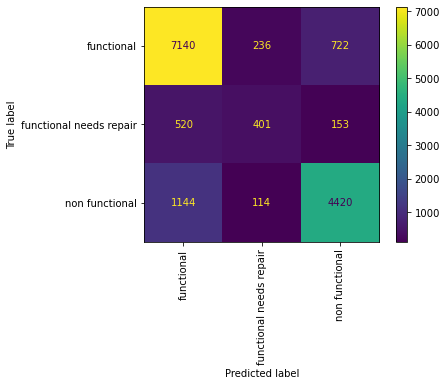

                         precision    recall  f1-score   support

             functional       0.81      0.88      0.84      8098
functional needs repair       0.53      0.37      0.44      1074
         non functional       0.83      0.78      0.81      5678

               accuracy                           0.81     14850
              macro avg       0.73      0.68      0.70     14850
           weighted avg       0.80      0.81      0.80     14850



In [11]:
y_pred = rf_f.predict(test_X)
cm=confusion_matrix(test_y, y_pred, labels=rf_f.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=rf_f.classes_)
plt.figure(figsize=(40,8))
disp.plot()
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()
print(classification_report(test_y, y_pred, labels=rf_f.classes_))

In [12]:
print(cross_val_score(rf_f, train_X, train_y, cv=5))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[0.80998878 0.80325477 0.8016835  0.8020202  0.79539843]


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.7s finished


In [13]:
rf_deets.to_pickle('Data/scores/RF.pkl')